In [110]:
import numpy as np
import pandas as pd
from sklearn import datasets
import math
from tqdm import tqdm

import random
from sklearn.datasets.samples_generator import make_regression
import pylab
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction import DictVectorizer

import matplotlib.pyplot as plt


In [111]:
# Загружаем датасет
data = sns.load_dataset("iris")

# Исключаем вид 'setosa' из данных
iris_data = data.drop(data[(data.species == 'setosa')].index)

# Заменяем категориальные значения сорта на 1 и 0
def get_species(row):
    if row['species'] == 'versicolor':
        return 0
    else:
        return 1
    
iris_data['spec'] = data.apply(get_species, axis=1)
iris_data.drop(['species'], axis=1, inplace=True)
iris_data

,sepal_length,sepal_width,petal_length,petal_width,spec
50,7.0,3.2,4.7,1.4,0
51,6.4,3.2,4.5,1.5,0
52,6.9,3.1,4.9,1.5,0
53,5.5,2.3,4.0,1.3,0
54,6.5,2.8,4.6,1.5,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,1
146,6.3,2.5,5.0,1.9,1
147,6.5,3.0,5.2,2.0,1
148,6.2,3.4,5.4,2.3,1


In [112]:
# Выбираем данные для обучения модели
x_train, x_test, y_train, y_test = train_test_split(iris_data.iloc[:, :-1], iris_data.iloc[:, -1], test_size=0.2, random_state=42)


###### 1. Метод градиентного спуска

In [113]:
# Реализуем метод градиентного спуска
def gradient_descent(x_data, y_data, learning_rate,iterations,parameters): 
    size = x_data.shape[0]
    weight = parameters["weight"] 
    bias = parameters["bias"]
    loss_list = []
    accuracy_list = []
    
    for i in tqdm(range(iterations)): 
        prediction = 1 / (1 + np.exp(-(np.dot(x_data, weight) + bias)))
        loss = -1/size * np.sum(y_data * np.log(prediction) + (1 - y_data) * np.log(1-prediction))
        
        dW = 1/size * np.dot(x_data.T, (prediction - y_data))
        db = 1/size * np.sum(prediction - y_data)
        
        weight -= learning_rate * dW
        bias -= learning_rate * db
        loss_list.append(loss)

        
    parameters["weight"] = weight
    parameters["bias"] = bias
    parameters["loss_list"] = loss_list
    
    return parameters

init_parameters = {} 
init_parameters["weight"] = np.ones(x_train.shape[1])
init_parameters["bias"] = 0.0

In [114]:
def train(x_data, y_data, learning_rate,iterations):
    parameters = gradient_descent(x_data, y_data, learning_rate, iterations, init_parameters)
    return parameters

parameters_gd = train(x_train, y_train, learning_rate = 0.01, iterations = 1000)
parameters_gd["weight"]

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1602.55it/s]


array([-0.87177326, -0.27001139,  0.94408968,  1.36295829])

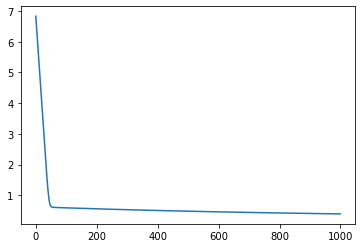

In [115]:
plt.plot(parameters_gd['loss_list']);

In [116]:
predict = 1 / (1 + np.exp(-(np.dot(x_test, parameters['weight']) + parameters['bias'])))
predict

array([5.81357949e-01, 9.98271688e-01, 9.99761582e-01, 1.11089319e-04,
       4.28519357e-03, 6.29390127e-03, 7.65811485e-01, 9.99804718e-01,
       1.42019250e-03, 1.59516889e-04, 7.10387264e-01, 3.82776842e-04,
       9.45428485e-01, 9.54569261e-01, 9.99956520e-01, 2.06326273e-02,
       8.40573698e-01, 7.58936606e-01, 5.86981142e-04, 6.42160837e-05])

In [117]:
predict2 = predict > 0.5
predict2 * 1

array([1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0])

In [118]:
accuracy_score(predict2, y_test)

0.85

###### 2. Метод nesterov momentum

In [119]:
# Реализуем метод nesterov momentum
def gradient_descent_nesterov(x_data, y_data, learning_rate, beta, iterations, parameters): 
    size = x_data.shape[0]
    weight = parameters["weight"] 
    bias = parameters["bias"]
    momentum = parameters["momentum"]
    gamma = 0.7
    
    first_run = True
    
    loss_list = []
    accuracy_list = []
    
    
    for i in tqdm(range(iterations)):
        prediction = 1 / (1 + np.exp(-(np.dot(x_data, weight) + bias)))
        loss = -1/size * np.sum(y_data * np.log(prediction) + (1 - y_data) * np.log(1-prediction))

        dW = 1/size * np.dot(x_data.T, (prediction - y_data))

        weigh_temp = weight - gamma*momentum
        weight = weigh_temp - learning_rate*dW

        momentum = gamma*momentum + learning_rate*weigh_temp

        db = 1/size * np.sum(prediction - y_data)     
        bias -= learning_rate * db            

        if i % 100 == 0:
            loss_list.append(loss)
        
    parameters["weight"] = weight
    parameters["bias"] = bias
    parameters["loss_list"] = loss_list
    
    return parameters


In [120]:
def train_nesterov(x_data, y_data, beta, learning_rate,iterations):
    parameters = gradient_descent_nesterov(x_data, y_data, learning_rate, beta, iterations, init_parameters)
    return parameters

init_parameters = {} 
init_parameters["weight"] = np.zeros(x_train.shape[1])
init_parameters["bias"] = 0.0
init_parameters["momentum"] = 0.0

parameters_nesterov = train_nesterov(x_train, y_train, learning_rate = 0.01, beta = 0.9, iterations = 30000)
parameters_nesterov["weight"]

100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:18<00:00, 1636.01it/s]


array([0.0603223 , 0.01276924, 0.1305117 , 0.07082142])

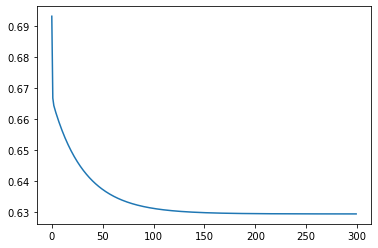

In [121]:
plt.plot(parameters_nesterov['loss_list']);

In [122]:
predict = 1 / (1 + np.exp(-(np.dot(x_test, parameters_nesterov['weight']) + parameters_nesterov['bias'])))
predict

array([0.52584445, 0.5476671 , 0.56948131, 0.48278769, 0.48209333,
       0.47343859, 0.51837594, 0.58143447, 0.44290172, 0.52286317,
       0.50286727, 0.46309491, 0.5243151 , 0.52277886, 0.56474072,
       0.51256701, 0.5198722 , 0.52226114, 0.47470616, 0.45809289])

In [123]:
predict2 = predict > 0.5
predict2 * 1

array([1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0])

In [124]:
accuracy_score(predict2, y_test)

0.75

###### 3. Метод rmsprop

In [125]:
# Реализуем метод rmsprop 
def gradient_descent_rmsprop(x_data, y_data, learning_rate,iterations,parameters):
    size = x_data.shape[0]
    weight = parameters["weight"] 
    bias = parameters["bias"]
    loss_list = []
    accuracy_list = []
    v_w, v_b = 0, 0
    eta = 0.01
    eps = 1e-8
    beta = 0.9
    
    for i in tqdm(range(iterations)): 
        prediction = 1 / (1 + np.exp(-(np.dot(x_data, weight) + bias)))
        loss = -1/size * np.sum(y_data * np.log(prediction) + (1 - y_data) * np.log(1-prediction))
        
        dW = 1/size * np.dot(x_data.T, (prediction - y_data))
        db = 1/size * np.sum(prediction - y_data)
        
        v_w = beta * v_w + (1 - beta) * dW**2
        v_b = beta * v_b + (1 - beta) * db**2        
        
        
        weight -= (eta / np.sqrt(v_w) + eps) * dW
        bias -= (eta / np.sqrt(v_b) + eps) * db
        loss_list.append(loss)

        
    parameters["weight"] = weight
    parameters["bias"] = bias
    parameters["loss_list"] = loss_list
    
    return parameters


In [126]:
def train_rmsprop(x_data, y_data, learning_rate,iterations):
    parameters = gradient_descent_rmsprop(x_data, y_data, learning_rate, iterations, init_parameters)
    return parameters

init_parameters = {} 
init_parameters["weight"] = np.ones(x_train.shape[1])
init_parameters["bias"] = 0.0

parameters_rmsprop = train_rmsprop(x_train, y_train, learning_rate = 0.01, iterations = 1000)
parameters_rmsprop["weight"]

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1577.37it/s]


array([-2.14268564, -4.63165287,  4.62736048,  6.87528908])

In [127]:
predict3 = 1 / (1 + np.exp(-(np.dot(x_test, parameters_rmsprop['weight']) + parameters_rmsprop['bias'])))
predict3

array([0.56128061, 0.98462416, 0.99543489, 0.00360591, 0.03454702,
       0.04248668, 0.67048617, 0.99486682, 0.01623454, 0.00352391,
       0.61377421, 0.00701605, 0.86373222, 0.8849191 , 0.99850066,
       0.07614917, 0.75676195, 0.70799832, 0.00769406, 0.00223165])

In [128]:
predict3 = predict > 0.5
predict3 * 1

array([1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0])

In [129]:
accuracy_score(predict3, y_test)

0.75